It's pretty easy to display a map using rasterio:

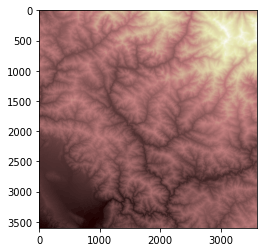

In [112]:
import rasterio
import os
from rasterio.transform import from_bounds, from_origin
from rasterio.warp import reproject, Resampling

dem_path = "output.tif"
dem_raster = rasterio.open(dem_path)
array = dem_raster.read(1)

# #tried to learn how to reproject - did not work
# north = 31
# east = 79
# west = 78
# south = 30

# src_crs = dem_raster.crs
# src_shape = src_height, src_width = dem_raster.shape
# src_transform = from_bounds(west, south, east, north, src_width, src_height)
# source = dem_raster.read(1)

# dst_crs = {'init': 'EPSG:32644'}
# dst_transform = from_origin(0, 0, 30, 30)
# dem_array = np.zeros((3601, 3601))
# dem_array[:] = np.nan

# reproject(source,
#           dem_array,
#           src_transform=src_transform,
#           src_crs=src_crs,
#           dst_transform=dst_transform,
#           dst_crs=dst_crs,
#           resampling=Resampling.bilinear)

from matplotlib import pyplot
pyplot.imshow(array, cmap='pink')
pyplot.show()

# from matplot

EPSG:4326


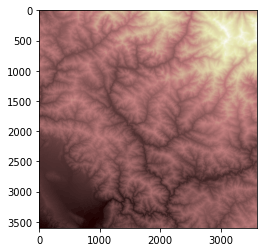

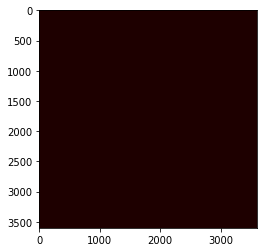

In [52]:
lib import pyplot
# pyplot.imshow(dem_array, cmap='pink')
# pyplot.show()

Using the elevation module to import a DEM from SRTM is still not working, though.

In [ ]:
# import elevation

# dem_path = '/data/external/Utt.tif'
# output = os.getcwd() + dem_path
# elevation.clip(bounds=(78.5, 30.5, 79, 31), output=output, product='SRTM1')
# dem_raster = rasterio.open(dem_path)
# array = dem_raster.read(1)

# from matplotlib import pyplot
# pyplot.imshow(array, cmap='pink')
# pyplot.show()

Now I want to try to calculate the slope and aspect of a DEM. I'll be following a tutorial from this youtube video: https://www.youtube.com/watch?v=5dDZeEXws9Q. I will use GDAL, but we could also use RichDEM (probably less work) if we could install it. We'll see that the aspect looks good, but the slope is basically all 90 degrees because it is not converted to meters. 

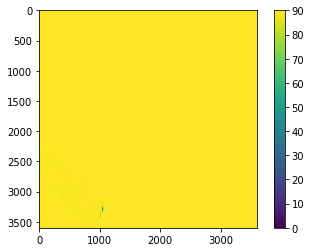

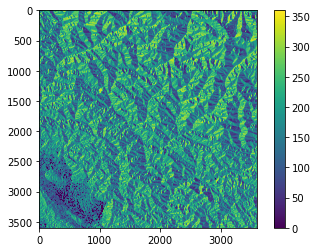

In [113]:
import os
import subprocess
from osgeo import gdal
import numpy as np
import rasterio
import matplotlib.pyplot as plt

def calculate_slope(DEM):
    slope = gdal.DEMProcessing('slope.tif', DEM, 'slope', computeEdges= True)
    slope_array = slope.GetRasterBand(1).ReadAsArray()
    return slope_array

def calculate_aspect(DEM):
    aspect = gdal.DEMProcessing('aspect.tif', DEM, 'aspect', computeEdges = True)
    aspect_array = aspect.GetRasterBand(1).ReadAsArray()
    return aspect_array

file = 'output.tif'
slope_array=calculate_slope(file)
aspect_array=calculate_aspect(file)


from matplotlib import pyplot
pyplot.imshow(slope_array)
pyplot.clim(0, 90)
pyplot.colorbar()
pyplot.show()

from matplotlib import pyplot
pyplot.imshow(aspect_array)
pyplot.clim(0, 360)
pyplot.colorbar()
pyplot.show()

In [114]:
!gdalsrsinfo ./n30_e078_1arc_v3.tif
#!gdalwarp -t_srs EPSG:4326 ./n30_e078_1arc_v3.tif output.tif


PROJ.4 : +proj=longlat +datum=WGS84 +no_defs

OGC WKT2:2018 :
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]



So, I did some fancy stuff in QGIS, and uploaded a custom slope map thing. Basically all I did was convert it to meters using a hack I found on Stack Overflow (https://gis.stackexchange.com/questions/143139/getting-incorrect-slope-values-from-an-aster-dem-in-qgis) - you need to know the latitude of the original map. Then, I displayed that slope map as a raster.

Note that just due to the way that QGIS saves things, this slope tif is now 618x618 pixels, instead of the original 3601x3601. So we go from arcdegrees to a little more detail than arcminutes. This is a big loss in resolution - hopefully there is a way to resolve it.

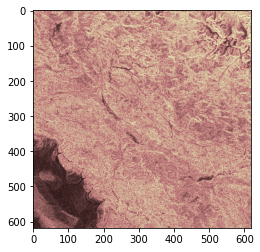

In [74]:
dem_path = "slope_m.tif"
dem_raster = rasterio.open(dem_path)
slope_array = dem_raster.read(1)

from matplotlib import pyplot
pyplot.imshow(slope_array, cmap='pink')
pyplot.show()

After that, I write a simple function to find the slope and aspect of a lat/lon query point (lat_q and lon_q). 

In [103]:
north, east, south, west = bounds = [31, 79, 30, 78]

lat_q = 30.8807
lon_q = 78.3975

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_values(lat_q, lon_q, bounds, array):
    size = len(array)
    step = 1/size
    north, east, south, west = bounds
    lat = np.arange(south, north, step)
    lon = np.arange(west, east, step)
    y = find_nearest(lat, lat_q)
    x = find_nearest(lon, lon_q)
    val = array[x,y]
    return val

def find_slope_aspect(lat_q, lon_q, bounds, slope_array, aspect_array):
    slope = find_value(lat_q, lon_q, bounds, slope_array)
    aspect = find_value(lat_q, lon_q, bounds, aspect_array)
    return slope, aspect

find_slope_aspect(lat_q, lon_q, bounds, slope_array, aspect_array)

(58, 310.03027)

I also tried to do stuff in Datashader. This took awhile and I am not convinced that it worked at all. But here's the code for it:

In [84]:
import numpy as np
import xarray as xr
from xarray import DataArray
import datashader as ds
import datashader.geo as dsgeo
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation

import warnings
warnings.filterwarnings("ignore")

infile  = "n30_e078_1arc_v3.tif"
da_dem = xr.open_rasterio(infile).drop('band')[0]

# Have to check the res property.
# No support for res in both directioins of (x, y) or (lat, lon).
da_dem.attrs['res'] = da_dem.attrs['res'][0]
nodata = da_dem.nodatavals[0]
da_dem = da_dem.where(da_dem>nodata, np.nan)

shade(da_dem, cmap=['black', 'white'], how='linear')
shade(da_dem, cmap=Elevation, how='linear')

illuminated = dsgeo.hillshade(da_dem)
shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear')

stack(shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear'),
      shade(da_dem ,     cmap=Elevation,         alpha=128, how='linear'))

risky = dsgeo.aspect(da_dem)
#risky.data = np.where(np.logical_and(risky.data > 25, risky.data < 50), 1, np.nan)

stack(shade(risky,      cmap=['black', 'white'], how='linear'),)

618

Arcpy is also an option, but also don't have that package - 

In [ ]:
import arcpy
from arcpy import env
from arcpy.sa import *

inRaster1 = "n30_e078_1arc_v3.tif"
outRas = slope(inRaster1)
outRas.save("slopeRas")